In [6]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.special import expn
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
save = False
plt.rcParams.update({"text.usetex": True,'font.family': 'serif','font.size':10})

In [7]:
# Parameters
numslices = 10
N = 128
srcplane = 63
boxsize = 22685/10 # comoving kpc, # /10 since in analytical solution assumes a = 1 at z = 9
dr = boxsize / N

# Instructions
Run the script `run_test.py` twice, as follows:
```
mkdir test_results
python run_test.py --gpu -mode coarse
mv test_results results_coarse
mkdir test_results
python run_test.py --gpu -mode fine
mv test_results results_fine
```
Caution: the "fine" output will take $\sim$ 14 Gb of disk space

In [ ]:
files_coarse = []
files_fine = []
prefix = "./"
for k in range(11):
    files_coarse.append(prefix + f"results_coarse/xfrac_{k:n}.pkl")
for k in range(101):
    files_fine.append(prefix + f"results_fine/xfrac_{k:n}.pkl")

In [9]:
slices_coarse = np.empty((len(files_coarse),int(N/2)+1))
for i,fn in enumerate(files_coarse):
    with open(fn,"rb") as f:
        slices_coarse[i] = pkl.load(f)[srcplane:,srcplane,srcplane]
slices_fine = np.empty((len(files_fine),int(N/2)+1))
for i,fn in enumerate(files_fine):
    with open(fn,"rb") as f:
        slices_fine[i] = pkl.load(f)[srcplane:,srcplane,srcplane]

In [10]:
# Analytical Solution
kpc = 3.086e21
year = 3.15576E+07
Ngamma = 1e54
nH = 1.87e-4
alpha_B = 2.59e-13

kpc_in_km = 3.0857e16 # km
myr_in_s = 31557600000000 # s

cosmology = FlatLambdaCDM(70, 0.27,2.726, Ob0=0.043)
ti = cosmology.age(9).to('Myr').value

r_S = ((3*Ngamma)/(4*np.pi*alpha_B*nH**2))**(1./3) / kpc
t_rec = 1.0 / (alpha_B*nH*year*1e6)
lam = ti / t_rec
print(lam)
print(ti)
print("r_S = ",r_S," kpc")
print("t_rec = ",t_rec," Myr")
def y(t):
    return lam*np.exp(lam*ti/t)*(t/ti*expn(2,lam*ti/t) - expn(2,lam))
def r_I(t):
    return r_S*(y(ti+t))**(1./3)
def r_I_noncosmo(t):
    return r_S * (1.0 - np.exp(-t/t_rec))**(1./3)
def v_I(t):
    return kpc_in_km/myr_in_s * r_S/(3*t_rec) * (np.exp(-t/t_rec))/(1.0 - np.exp(-t/t_rec))**(2./3)

0.862007470892602
563.9825828256307
r_S =  964.3770859478684  kpc
t_rec =  654.2664673678886  Myr


In [11]:
tt = np.linspace(0,500,200,endpoint=True)
tt_ = np.linspace(0,500,11,endpoint=True)
tt_fine = np.linspace(0,500,101,endpoint=True)
r_analytical = r_I(tt)
v_analytical = v_I(tt[1:])
x = np.linspace(0,boxsize/2,int(N/2)+1)

In [12]:
# Find position of ionization front by interpolation
# flip() is used because np.interp works on monotonically increasing functions only
front_pos_coarse = np.empty(11)
front_pos_fine = np.empty(len(files_fine))
for k in range(11):
    front_pos_coarse[k] = np.interp(0.5,np.flip(slices_coarse[k]),np.flip(x))
for k in range(len(files_fine)):
    front_pos_fine[k] = np.interp(0.5,np.flip(slices_fine[k]),np.flip(x))

In [13]:
raderr_coarse = front_pos_coarse[1:] / r_I(tt_[1:])
raderr_fine = front_pos_fine[1:] / r_I(tt_fine[1:])

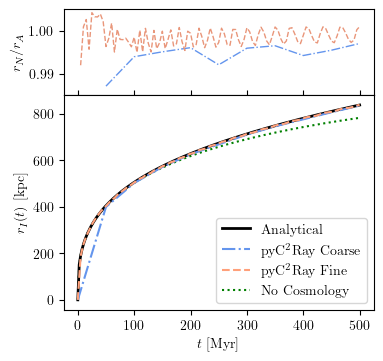

In [14]:
fig, ax = plt.subplots(2,1,figsize=(4,3.9),sharex=True,height_ratios=[2,5])

#ax[0].axhline(1,color='black')
ax[0].plot(tt_[1:],raderr_coarse,'-.',lw=1,label="pyC$^2$Ray Coarse",color='cornflowerblue')
ax[0].plot(tt_fine[1:],raderr_fine,'--',lw=1,color='darksalmon')
yspac = 0.013
ax[0].set_ylabel("$r_{N}/r_{A}$")
ax[0].set_ylim(0.985,1.005)
#ax[0].set_ylim(1-yspac,1+yspac)

l_nc, = ax[1].plot(tt,r_I_noncosmo(tt),':',color='green',label="No Cosmology")
l_an, = ax[1].plot(tt,r_analytical,color='black',label="Analytical",lw=2)
l_coarse, = ax[1].plot(tt_,front_pos_coarse,'-.',label="pyC$^2$Ray Coarse",color='cornflowerblue')
l_fine, = ax[1].plot(tt_fine,front_pos_fine,'--',ms=6,label="pyC$^2$Ray Fine",color='lightsalmon')


#ax[0].set_xlabel("$t$ [Myr]")
ax[1].set_ylabel("$r_I(t)$ [kpc]")
ax[1].tick_params(top=True)
ax[1].legend(handles=[l_an,l_coarse,l_fine,l_nc])

#ax[1].semilogy(tt_,front_vel_coarse,'^',label="pyC$^2$Ray Coarse",color='teal')

ax[1].set_xlabel("$t$ [Myr]")
ax[1].tick_params(top=True)
#ax[1].legend()
fig.subplots_adjust(hspace=0)

In [15]:
#fig.savefig("test4_new.eps",bbox_inches='tight')
fig.savefig("test2_Ifront_cosmo.png",bbox_inches='tight',dpi=400)